# Task 1.1 - Detecting fraudulent credit card transactions

This notebook involves training and testing of two baseline models in detecting frauds on the Machine Learning Group-ULB credit card dataset.

What does it do:
1. Loads 'creditcard.csv'
2. Selects smaller working sample (all fraud cases and a random sample of legitimate transactions) in order to save on runtime.
3. Trains two models:
   - Logistic Regression (class weights)
   - Random Forest (class weights)
4. Evaluates with 5-fold Stratified Cross-Validation (Precision, Recall, F1, PR-AUC)
5. Computes figures (confusion matrices and Precision-Recall curves) on a given hold-out split.


In [1]:
# Install (only needed in Colab sometimes)
# !pip -q install scikit-learn==1.4.2

import os
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay

import matplotlib.pyplot as plt

RANDOM_STATE = 42
DATA_PATH = "creditcard.csv"
OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [2]:
# Reproducibility (keeps results stable between runs)
import random
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)


In [3]:
# 1) Load dataset
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
print("Fraud count:", int(df["Class"].sum()))
print("Fraud ratio:", df["Class"].mean())
df.head()


Shape: (45646, 31)
Fraud count: 142
Fraud ratio: 0.003110965056413627


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [4]:
# 2) Make a smaller dataset for fast running (keep all fraud + 20x legit)
fraud = df[df["Class"]==1]
legit = df[df["Class"]==0]

RATIO = 20  # change to 50 for more data (slower but more stable)
legit_sample = legit.sample(n=RATIO*len(fraud), random_state=RANDOM_STATE)

df_small = pd.concat([fraud, legit_sample], axis=0).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

print("Small dataset shape:", df_small.shape)
print("Small fraud ratio:", df_small["Class"].mean())

X = df_small.drop(columns=["Class"])
y = df_small["Class"].astype(int)


Small dataset shape: (2982, 31)
Small fraud ratio: 0.047619047619047616


In [5]:
# 3) Preprocessing: scale Time + Amount only
num_scale = ["Time","Amount"]
passthrough = [c for c in X.columns if c not in num_scale]

preprocess = ColumnTransformer([
    ("scale", StandardScaler(), num_scale),
    ("pass", "passthrough", passthrough)
])


In [6]:
# 4) Two models (fast + standard)
pipe_lr = Pipeline([
    ("preprocess", preprocess),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="liblinear",
        random_state=RANDOM_STATE
    ))
])

pipe_rf = Pipeline([
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        max_features="sqrt",
        class_weight="balanced_subsample",
        n_jobs=-1,
        random_state=RANDOM_STATE
    ))
])


In [7]:
# 5) 5-fold Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

scoring = {
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "ap": "average_precision"  # PR-AUC
}

def summarize(name, res):
    out = {
        "model": name,
        "precision_mean": np.mean(res["test_precision"]),
        "precision_sd": np.std(res["test_precision"]),
        "recall_mean": np.mean(res["test_recall"]),
        "recall_sd": np.std(res["test_recall"]),
        "f1_mean": np.mean(res["test_f1"]),
        "f1_sd": np.std(res["test_f1"]),
        "ap_mean": np.mean(res["test_ap"]),
        "ap_sd": np.std(res["test_ap"]),
    }
    return out

res_lr = cross_validate(pipe_lr, X, y, cv=cv, scoring=scoring, n_jobs=1)
res_rf = cross_validate(pipe_rf, X, y, cv=cv, scoring=scoring, n_jobs=1)

tab = pd.DataFrame([
    summarize("Logistic Regression (balanced)", res_lr),
    summarize("Random Forest (balanced_subsample)", res_rf)
])

tab.to_csv(os.path.join(OUTPUT_DIR, "tab_cv_results.csv"), index=False)
tab


,model,precision_mean,precision_sd,recall_mean,recall_sd,f1_mean,f1_sd,ap_mean,ap_sd
0,Logistic Regression (balanced),0.762468,0.073932,0.950739,0.017118,0.843621,0.043287,0.951215,0.014782
1,Random Forest (balanced_subsample),0.977411,0.018531,0.908867,0.052365,0.941125,0.029959,0.963408,0.030257


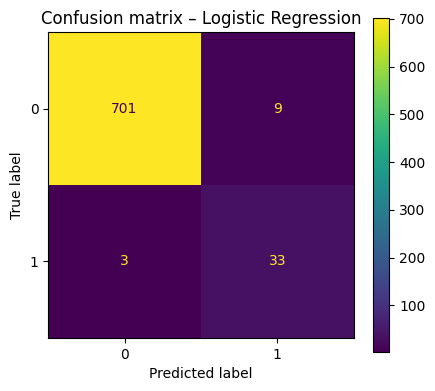

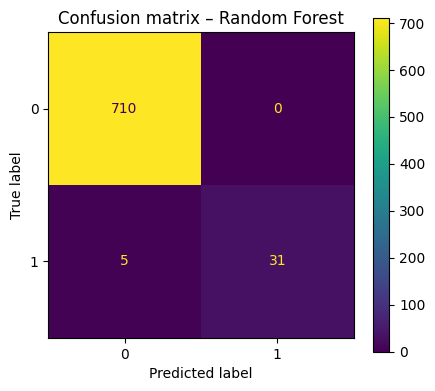

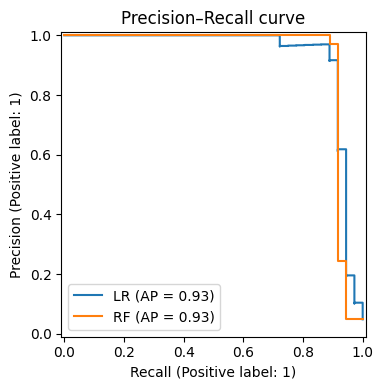

In [8]:
# 6) Optional plots on a hold-out split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE)

pipe_lr.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)

# Confusion matrices
fig, ax = plt.subplots(figsize=(4.5,4))
ConfusionMatrixDisplay.from_estimator(pipe_lr, X_test, y_test, ax=ax, values_format="d")
ax.set_title("Confusion matrix – Logistic Regression")
fig.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR, "fig_cm_lr.png"), dpi=300)
plt.show()

fig, ax = plt.subplots(figsize=(4.5,4))
ConfusionMatrixDisplay.from_estimator(pipe_rf, X_test, y_test, ax=ax, values_format="d")
ax.set_title("Confusion matrix – Random Forest")
fig.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR, "fig_cm_rf.png"), dpi=300)
plt.show()

# Precision–Recall curve
fig, ax = plt.subplots(figsize=(6,4))
PrecisionRecallDisplay.from_estimator(pipe_lr, X_test, y_test, ax=ax, name="LR")
PrecisionRecallDisplay.from_estimator(pipe_rf, X_test, y_test, ax=ax, name="RF")
ax.set_title("Precision–Recall curve")
fig.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR, "fig_pr_curves.png"), dpi=300)
plt.show()
